<h1 style='color:purple' align='center'>Data Science Regression Project: Predicting Home Prices in Bengaluru</h1>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Load locally from the system

df = pd.read_csv("bengaluru_house_prices.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df.shape

(13320, 9)

In [4]:
df.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [5]:
df['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [6]:
df['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

## Distribution of House Prices

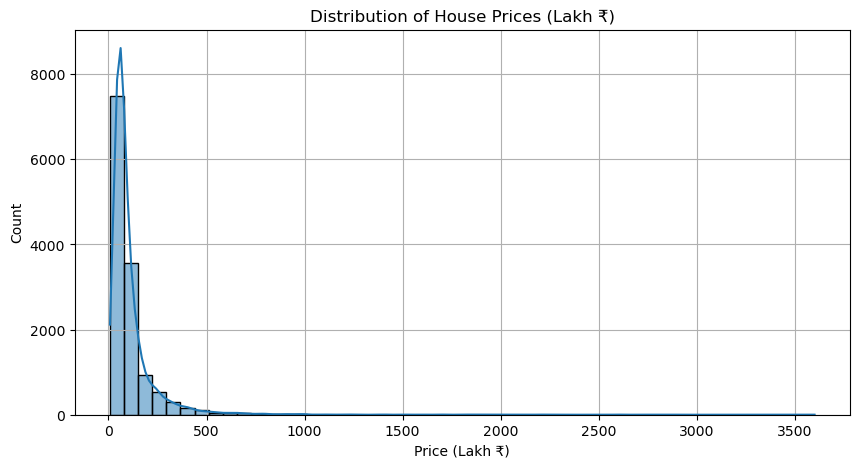

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of House Prices (Lakh ₹)')
plt.xlabel('Price (Lakh ₹)')
plt.ylabel('Count')
plt.grid(True)
plt.show()


## Area Type Counts

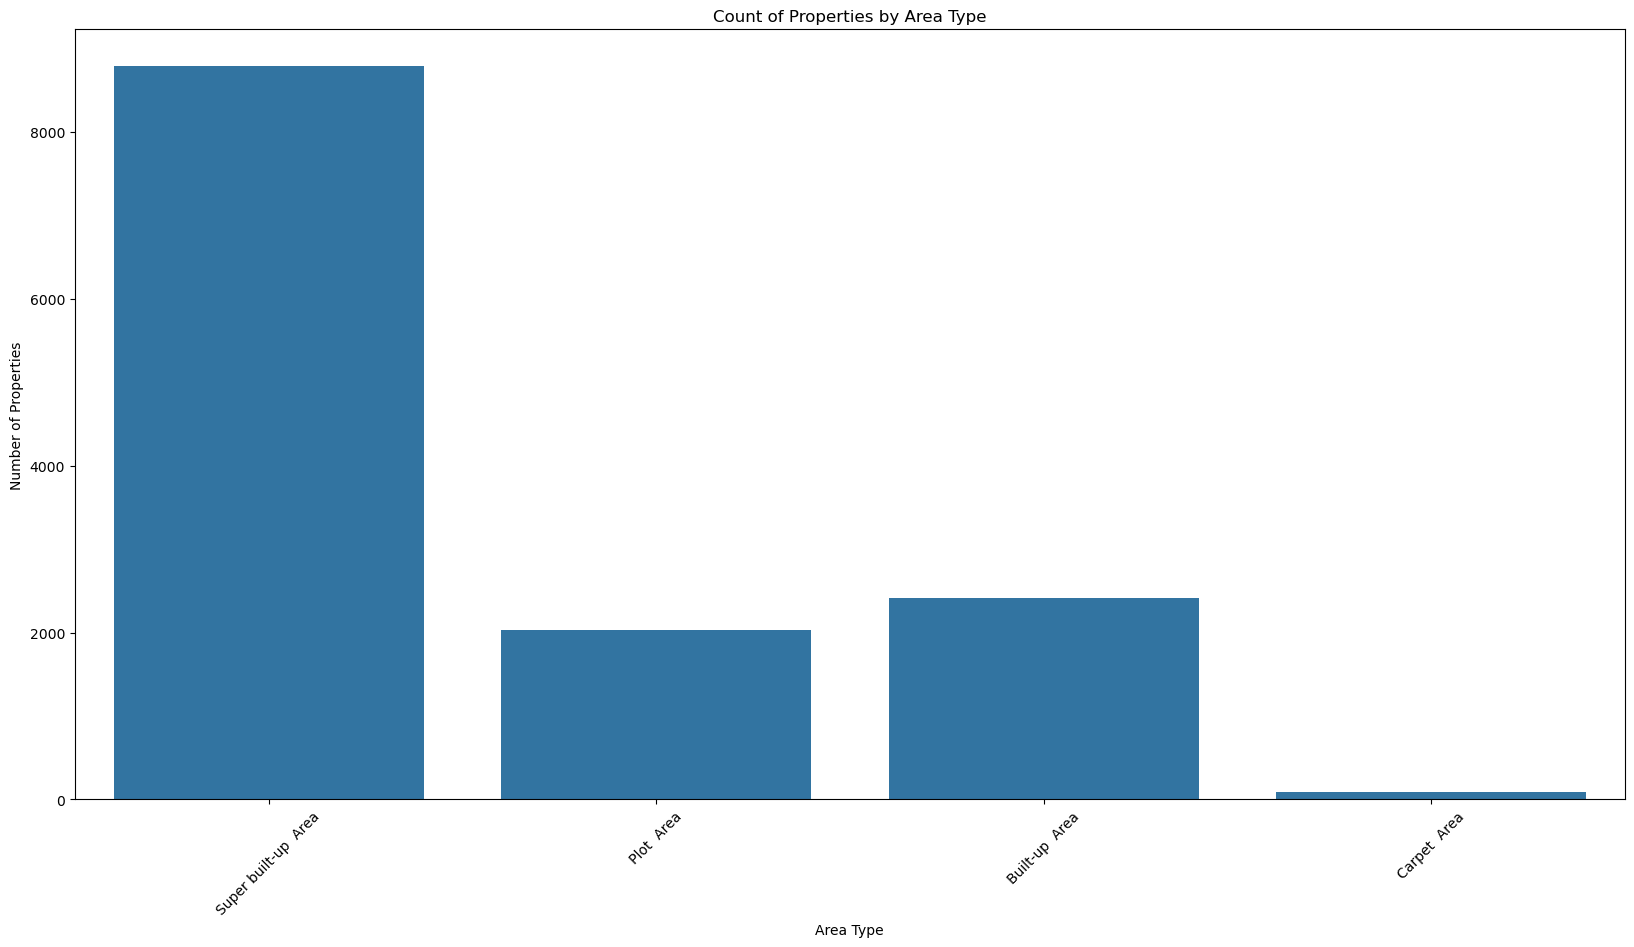

In [8]:
sns.countplot(x='area_type', data=df)
plt.title('Count of Properties by Area Type')
plt.xlabel('Area Type')
plt.ylabel('Number of Properties')
plt.xticks(rotation=45)
plt.show()


## Top 10 Most Common Locations

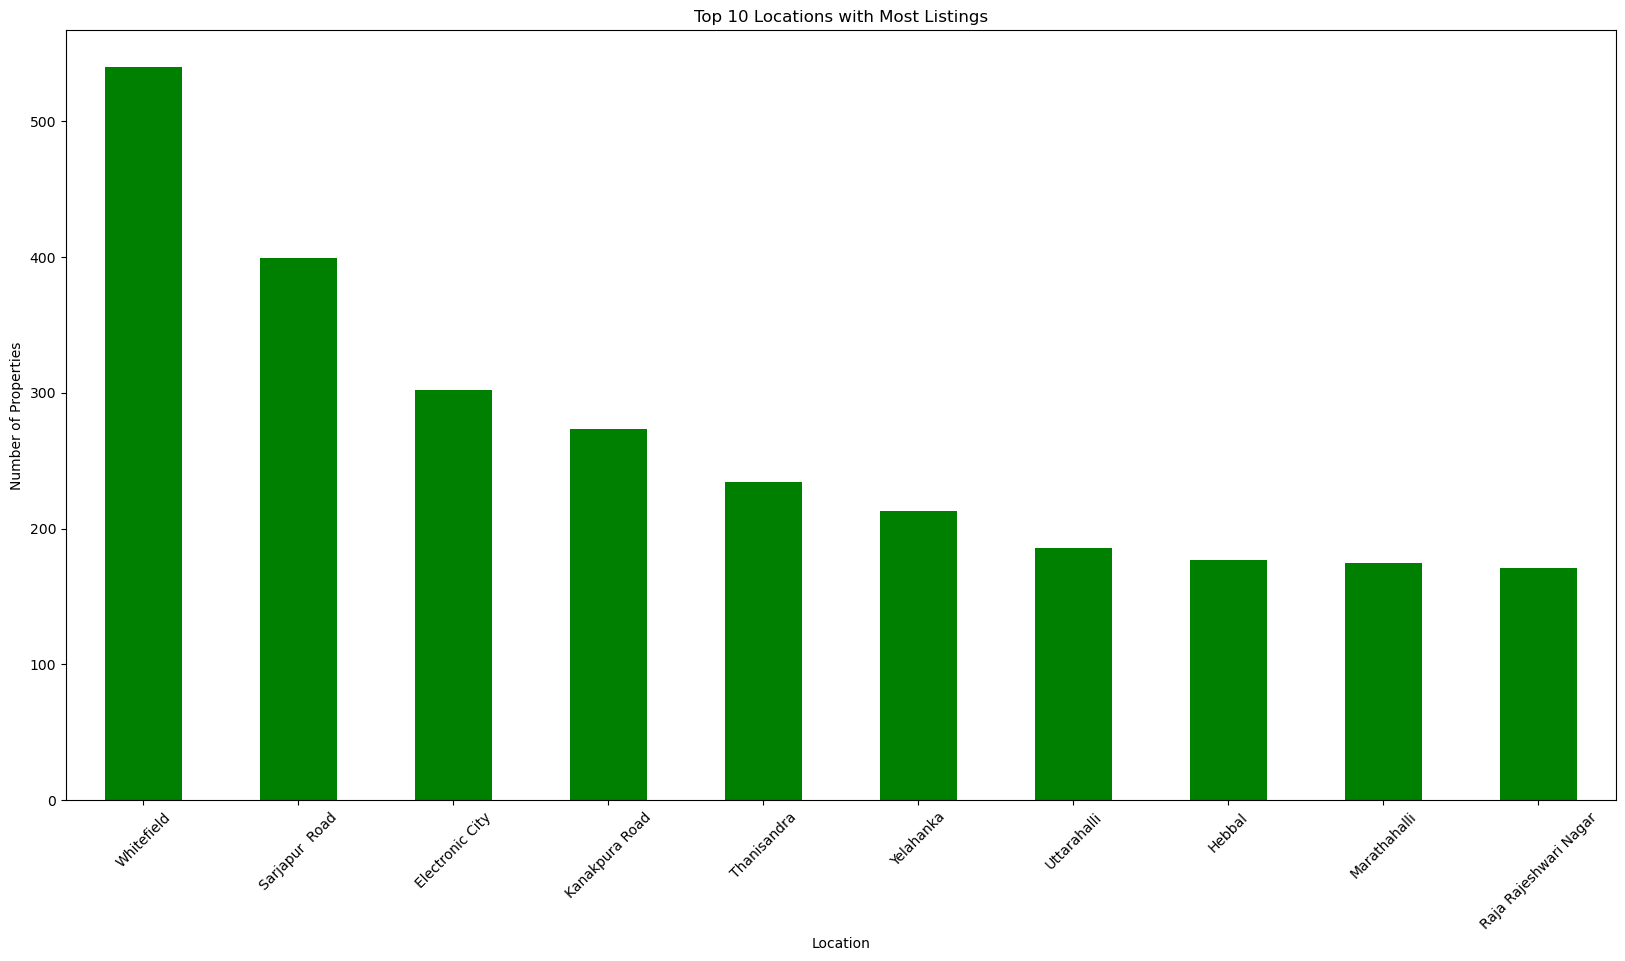

In [9]:
top_locations = df['location'].value_counts().head(10)
top_locations.plot(kind='bar', color='green')
plt.title('Top 10 Locations with Most Listings')
plt.xlabel('Location')
plt.ylabel('Number of Properties')
plt.xticks(rotation=45)
plt.show()


## Location vs Average Price (Top 20 Locations)

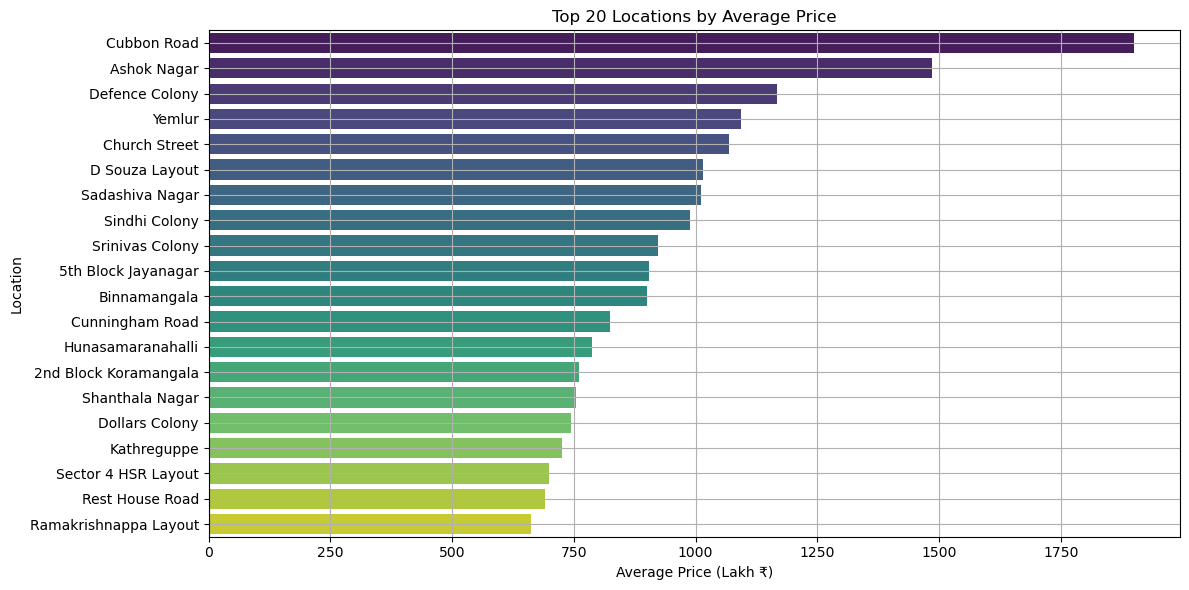

In [10]:
location_price = df.groupby('location')['price'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x=location_price.values, y=location_price.index, palette='viridis')
plt.title('Top 20 Locations by Average Price')
plt.xlabel('Average Price (Lakh ₹)')
plt.ylabel('Location')
plt.grid(True)
plt.tight_layout()
plt.show()


## Price vs Total Sqft

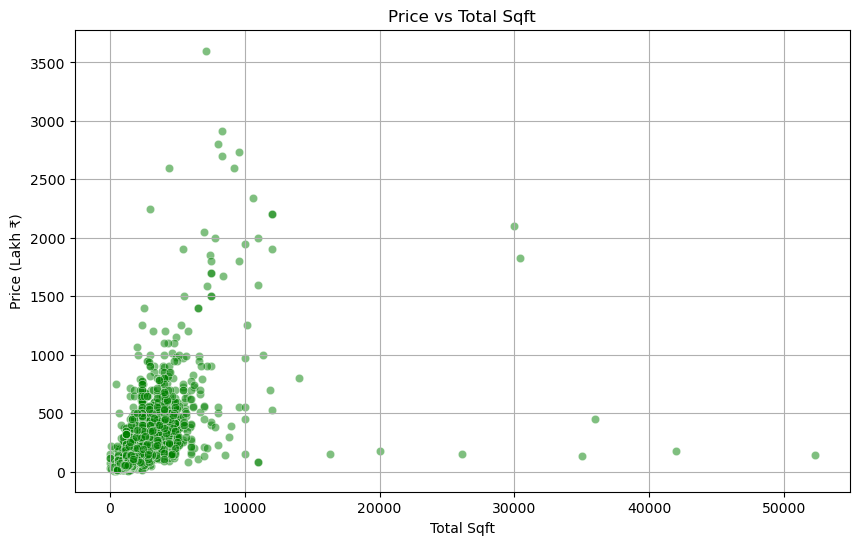

In [11]:
# Clean total_sqft if necessary (some values are ranges or non-numeric)
def convert_sqft(x):
    try:
        return float(x)
    except:
        if '-' in x:
            tokens = x.split('-')
            return (float(tokens[0]) + float(tokens[1])) / 2
        else:
            return None

df['total_sqft'] = df['total_sqft'].apply(convert_sqft)
df = df.dropna(subset=['total_sqft', 'price'])

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_sqft', y='price', data=df, alpha=0.5, color='green')
plt.title('Price vs Total Sqft')
plt.xlabel('Total Sqft')
plt.ylabel('Price (Lakh ₹)')
plt.grid(True)
plt.show()


**Drop features that are not required to build our model**

## Boxplot: Price Distribution by Number of Bathrooms

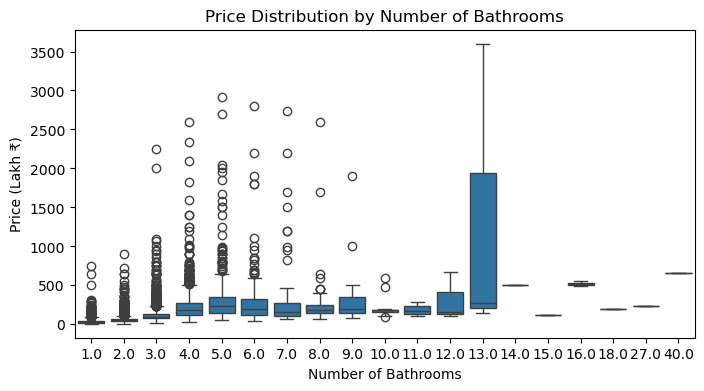

In [12]:
plt.figure(figsize=(8,4))
sns.boxplot(x='bath', y='price', data=df)
plt.title('Price Distribution by Number of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price (Lakh ₹)')
plt.show()


## Top Availabililty Status Categories


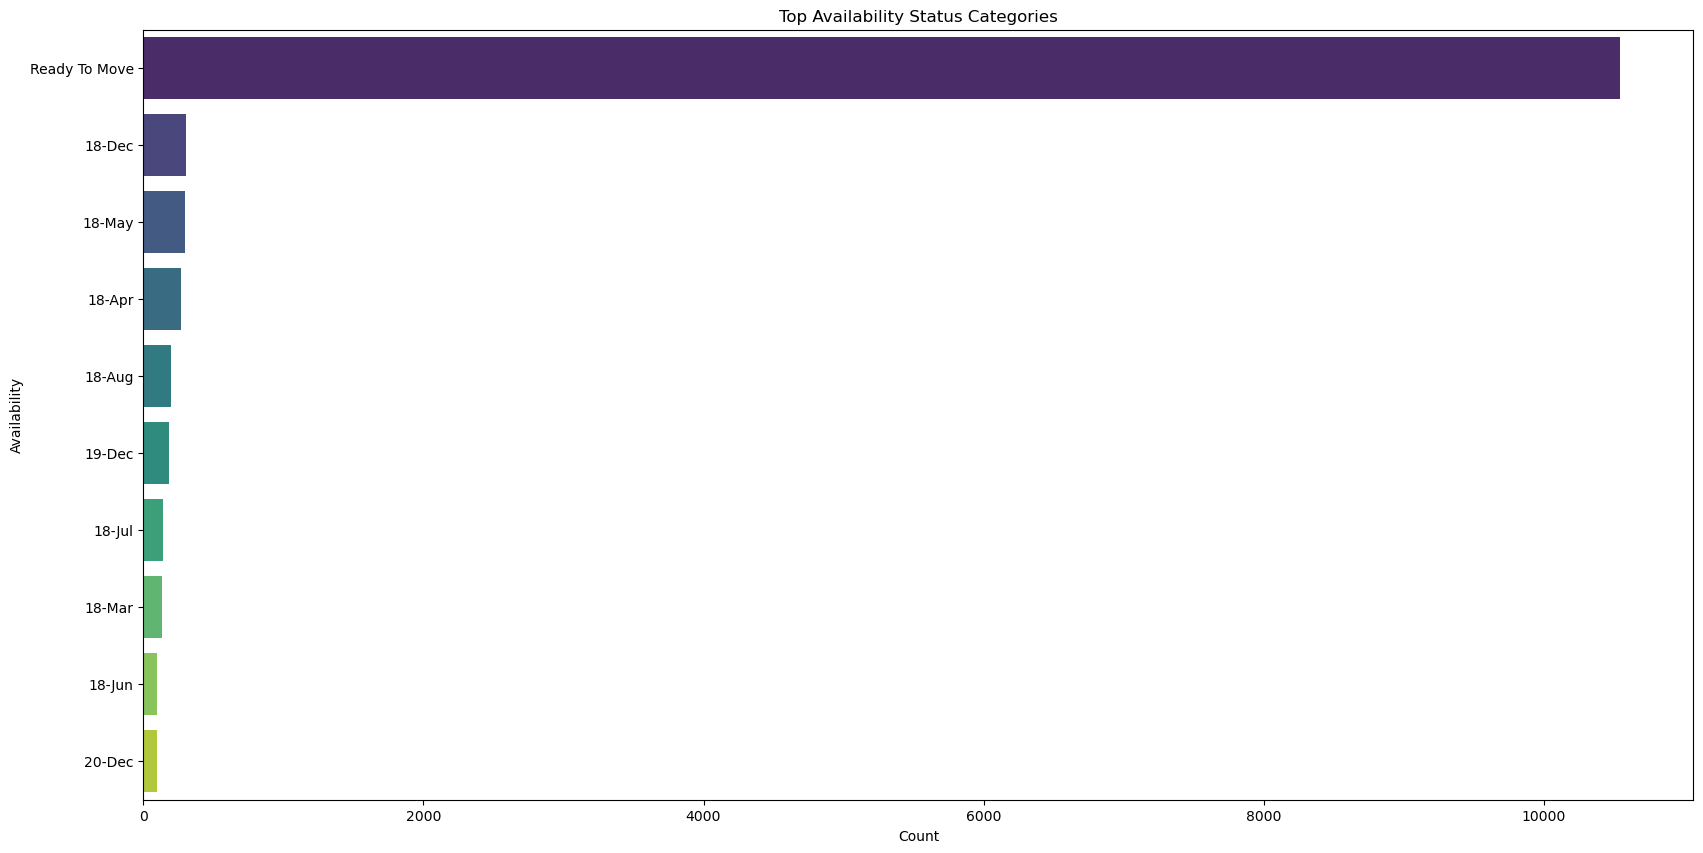

In [13]:
sns.countplot(data=df, y='availability', order=df['availability'].value_counts().head(10).index, palette='viridis')
plt.title('Top Availability Status Categories')
plt.xlabel('Count')
plt.ylabel('Availability')
plt.show()


In [14]:
df1 = df.drop(['area_type','society','balcony','availability'],axis='columns')
df1.shape

(13274, 5)

<h2 style='color:blue'>Data Cleaning: Handle NA values</h2>

In [15]:
df1.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [16]:
df1.shape

(13274, 5)

In [17]:
df2 = df1.dropna()
df2.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [18]:
df2.shape

(13200, 5)

In [19]:
df2['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

<h2 style='color:blue'>Feature Engineering</h2>

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [20]:
df2 = df2.copy()  # Create a copy of the DataFrame
df2['bhk'] = df2['size'].apply(lambda x: int(x.split(' ')[0]))
df2.bhk.unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

**Explore total_sqft feature**

In [21]:
df2['total_sqft'].unique()

array([1056. , 2600. , 1440. , ..., 1258.5,  774. , 4689. ])

In [22]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [23]:
2+3

5

In [24]:
df2[~df2['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk


**Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple**

In [25]:
def convert_sqft_to_num(x):
    try:
        if isinstance(x, str):
            # If it's a range like "2100 - 2850"
            if '-' in x:
                tokens = x.split('-')
                if len(tokens) == 2:
                    return (float(tokens[0]) + float(tokens[1])) / 2
            # If it's a clean number
            return float(x)
        # If it's already a number, return it
        return float(x)
    except:
        return None  # return None if conversion fails


In [26]:
convert_sqft_to_num('2166')

2166.0

In [27]:
convert_sqft_to_num('2100 - 2850')

2475.0

In [28]:
convert_sqft_to_num('34.46Sq. Meter')

In [29]:
df3 = df2.copy()
df3.total_sqft = df3.total_sqft.apply(convert_sqft_to_num)
df3 = df3[df3.total_sqft.notnull()]
df3.head(3)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3


**For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850**

In [30]:
df3.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [31]:
(2100+2850)/2

2475.0

<h2 style="color:blue">Feature Engineering</h2>

**Add new feature called price per square feet**

In [32]:
df4 = df3.copy()
df4['price_per_sqft'] = df4['price']*100000/df4['total_sqft']
df4.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [33]:
df4_stats = df4['price_per_sqft'].describe()
df4_stats

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [34]:
df4.to_csv("bhp.csv",index=False)

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [35]:
len(df4.location.unique())

1298

In [36]:
df4.location = df4.location.apply(lambda x: x.strip())

location_stats = df4['location'].value_counts(ascending=False)
location_stats

location
Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: count, Length: 1287, dtype: int64

In [37]:
location_stats.values.sum()

13200

In [38]:
len(location_stats[location_stats>10])

240

In [39]:
len(location_stats)

1287

In [40]:
len(location_stats[location_stats<=10])

1047

<h2 style="color:blue">Dimensionality Reduction</h2>

**Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns**

In [41]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
BTM 1st Stage                10
Gunjur Palya                 10
Nagappa Reddy Layout         10
Sector 1 HSR Layout          10
Thyagaraja Nagar             10
                             ..
Rajanna Layout                1
Subramanyanagar               1
Lakshmipura Vidyaanyapura     1
Malur Hosur Road              1
Abshot Layout                 1
Name: count, Length: 1047, dtype: int64

In [42]:
len(df4.location.unique())

1287

In [43]:
df4.location = df4.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df4.location.unique())


241

In [44]:
df4.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


<h2 style="color:blue">Outlier Removal Using Business Logic</h2>

**As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [45]:
df4[df4.total_sqft/df4.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


**Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely**

In [46]:
df.shape

(13274, 9)

In [47]:
df5 = df4[~(df4.total_sqft/df4.bhk<300)]
df5.shape

(12456, 7)

<h2 style='color:blue'>Outlier Removal Using Standard Deviation and Mean</h2>

In [48]:
df5.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

**Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [49]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df6 = remove_pps_outliers(df5)
df6.shape

(10242, 7)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

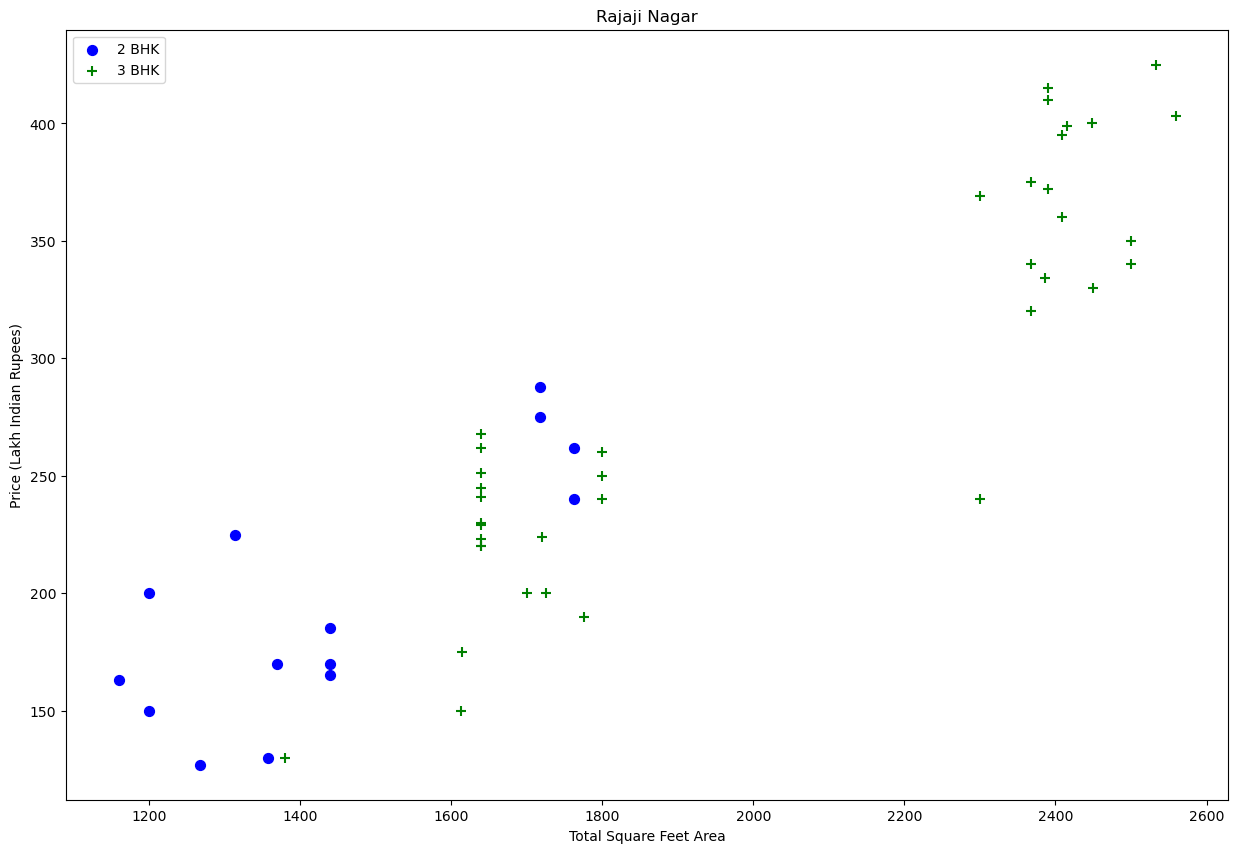

In [50]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    plt.show()

plot_scatter_chart(df6,"Rajaji Nagar")

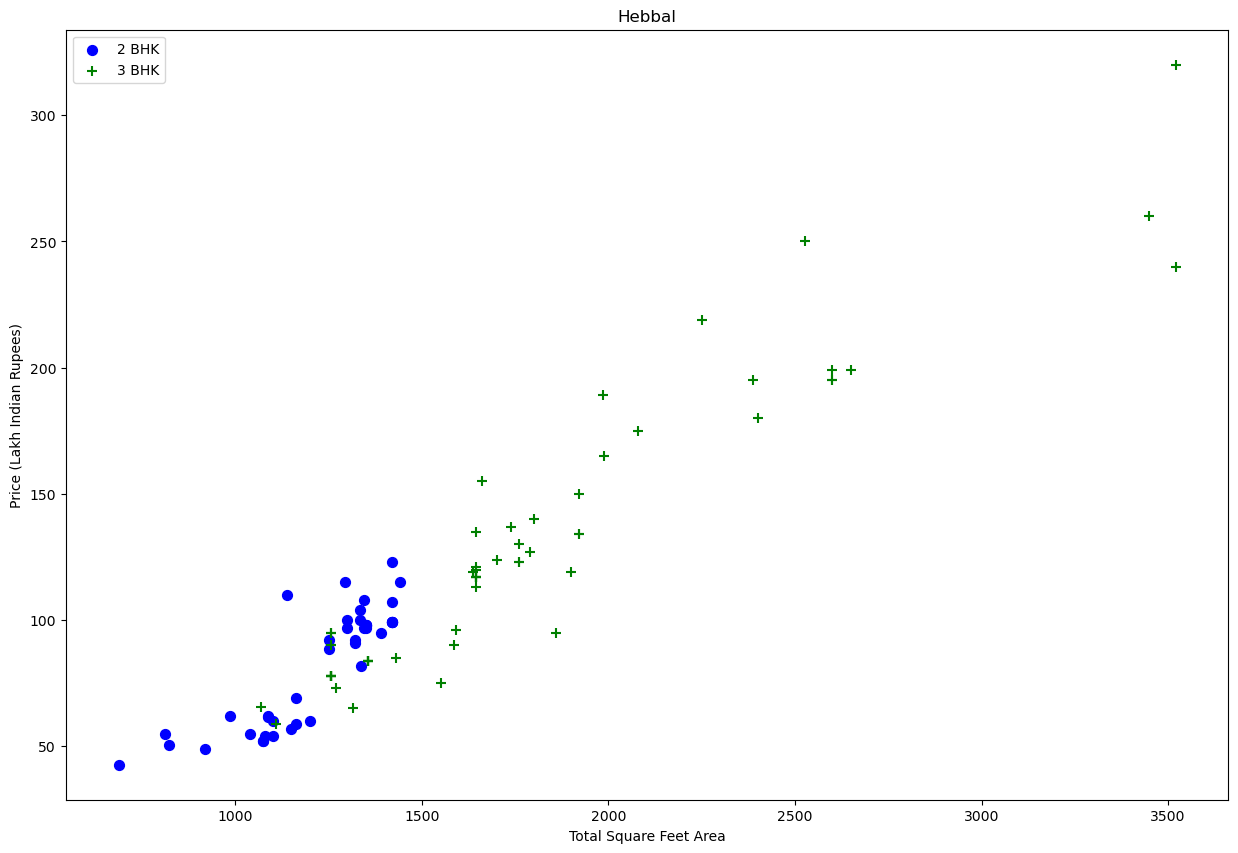

In [51]:
plot_scatter_chart(df6,"Hebbal")

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**
```
{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}
```
**Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [52]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df7 = remove_bhk_outliers(df6)
# df7 = df6.copy()
df7.shape

(7317, 7)

**Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties**

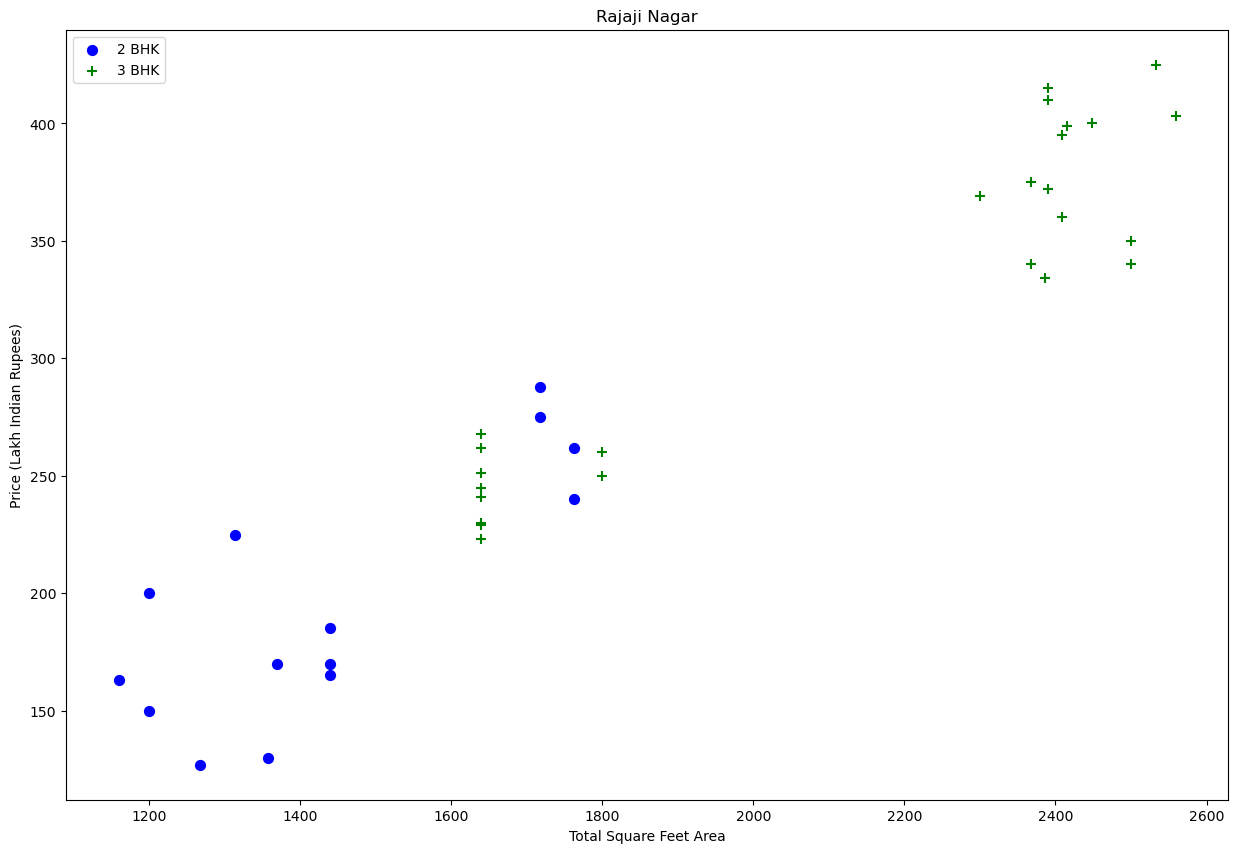

In [53]:
plot_scatter_chart(df7,"Rajaji Nagar")

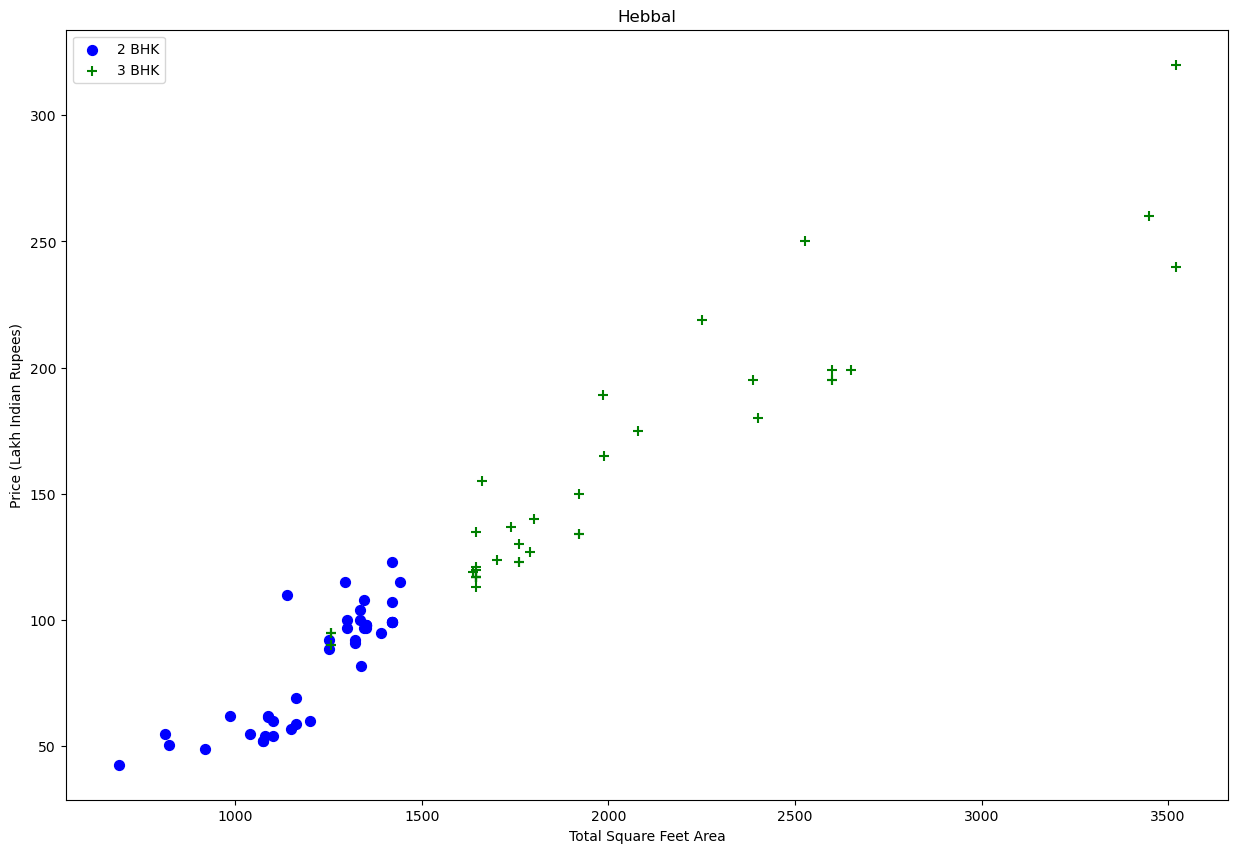

In [54]:
plot_scatter_chart(df7,"Hebbal")

**Based on above charts we can see that data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function**

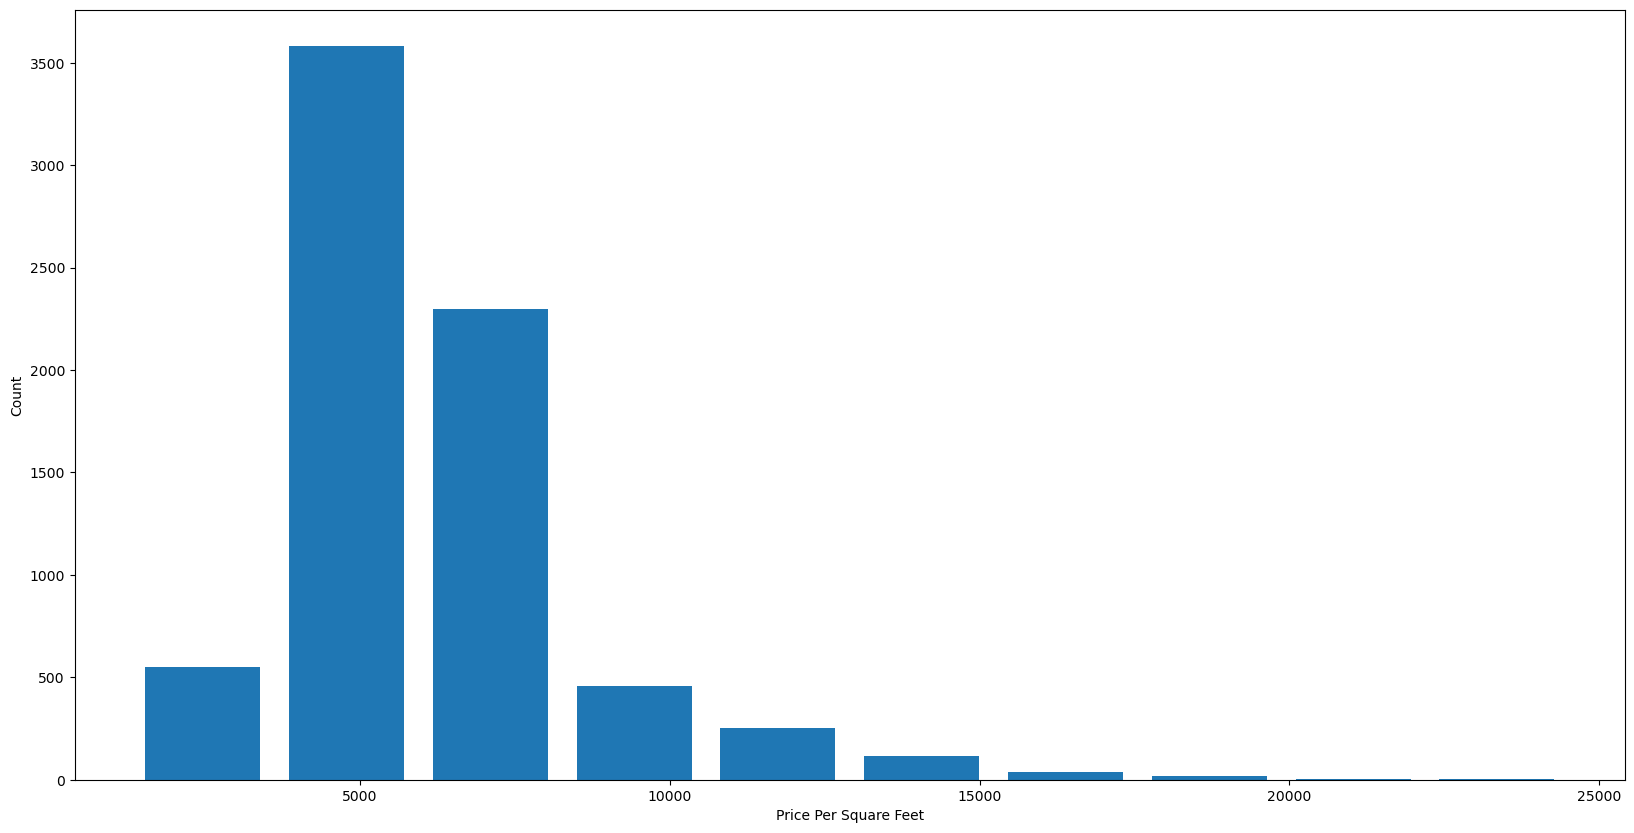

In [55]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df7.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")
plt.show()

<h2 style='color:blue'>Outlier Removal Using Bathrooms Feature</h2>

In [56]:
df7.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

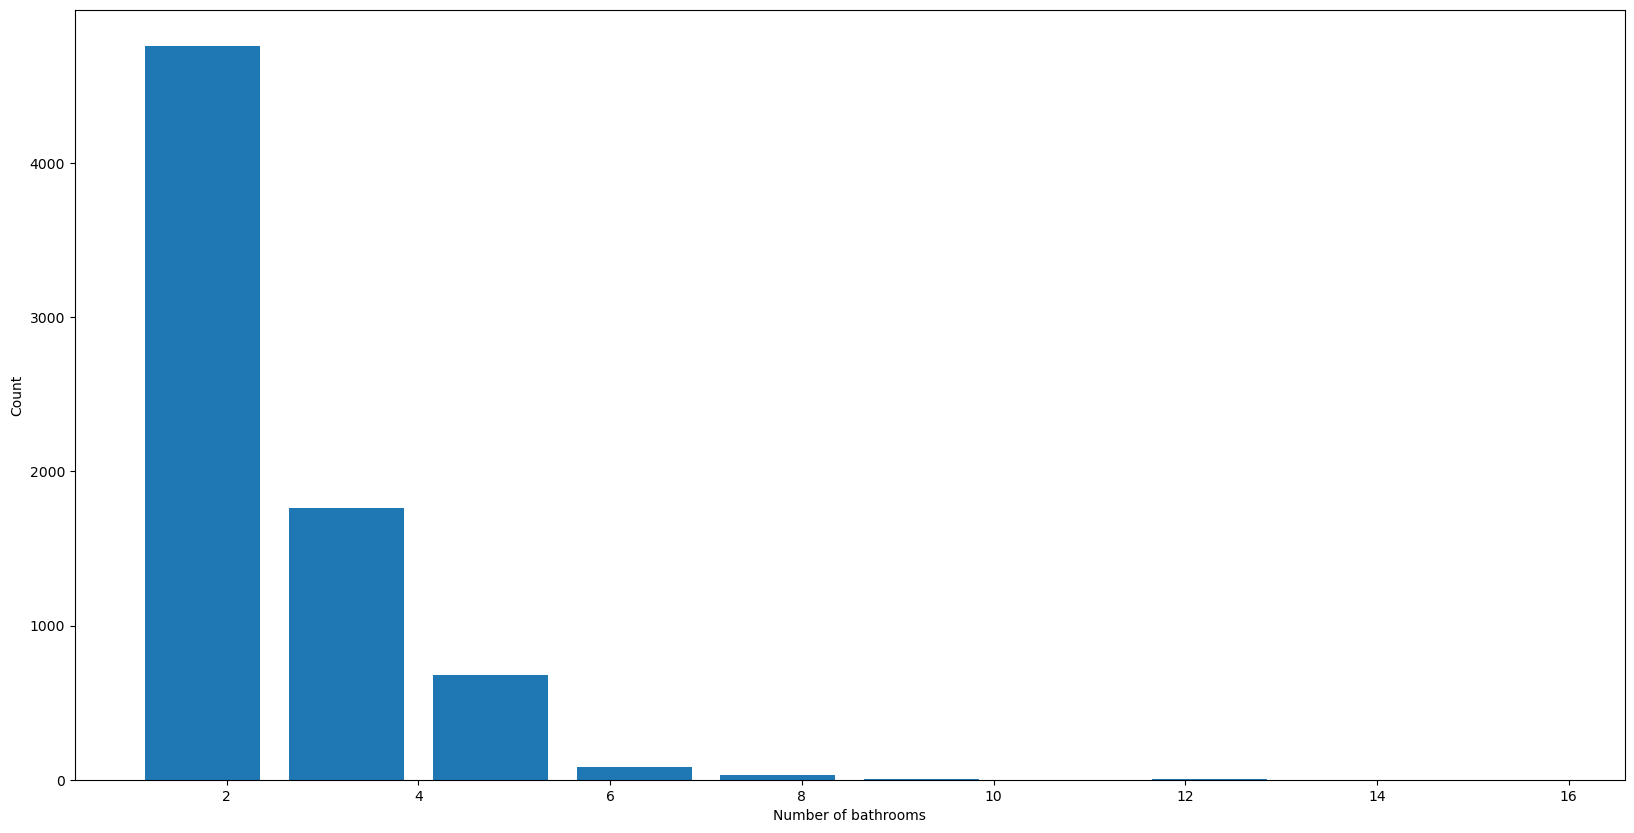

In [57]:
plt.hist(df7.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")
plt.show()

In [58]:
df7[df7.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [59]:
df7[df7.bath>df7.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8408,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


**Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed**

In [60]:
df8 = df7[df7.bath<df7.bhk+2]
df8.shape

(7239, 7)

In [61]:
df8.head(3)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333


In [62]:
df9 = df8.drop(['size','price_per_sqft'],axis='columns')
df9.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


<h2 style='color:blue'>Use One Hot Encoding For Location</h2>

In [63]:
dummies = pd.get_dummies(df9.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [64]:
df10 = pd.concat([df9,dummies.drop('other',axis='columns')],axis='columns')
df10.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1st Block Jayanagar,1630.0,3.0,194.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1st Block Jayanagar,1875.0,2.0,235.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1st Block Jayanagar,1200.0,2.0,130.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1st Block Jayanagar,1235.0,2.0,148.0,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [65]:
df11 = df10.drop('location',axis='columns')
df11.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,194.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<h2 style='color:blue'>Build a Model Now...</h2>

In [66]:
df11.shape

(7239, 244)

In [67]:
X = df11.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1875.0,2.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [68]:
X.shape

(7239, 243)

In [69]:
y = df11.price
y.head(3)

0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

In [70]:
len(y)

7239

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [72]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)


LinearRegression()

In [73]:
model.score(X_test,y_test)

0.862913224522944

<h2 style='color:blue'>Use K Fold cross validation to measure accuracy of our LinearRegression model</h2>

In [74]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.82702546, 0.86027005, 0.85322178, 0.8436466 , 0.85481502])

**We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose**

<h2 style='color:blue'>Find best model using GridSearchCV</h2>

In [75]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit
import pandas as pd
from tqdm import tqdm

def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'positive': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 2]
            }
        },
        'ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [1, 10]
            }
        },
        'elasticnet': {
            'model': ElasticNet(),
            'params': {
                'alpha': [0.1, 1],
                'l1_ratio': [0.2, 0.8]
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error'],
                'max_depth': [10, 20]
            }
        },
        'random_forest': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [50],
                'max_depth': [None, 20]
            }
        },
        'gradient_boosting': {
            'model': GradientBoostingRegressor(),
            'params': {
                'n_estimators': [100],
                'learning_rate': [0.1],
                'max_depth': [3, 5]
            }
        },
        'knn': {
            'model': KNeighborsRegressor(),
            'params': {
                'n_neighbors': [3, 5]
            }
        }
        # SVR removed for speed
    }

    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    print("Training models with GridSearchCV...")
    for algo_name, config in tqdm(algos.items()):
        gs = GridSearchCV(config['model'], config['params'], cv=cv, n_jobs=-1, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
find_best_model_using_gridsearchcv(X,y)

Training models with GridSearchCV...


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:17<00:00, 17.20s/it]


,model,best_score,best_params
0,linear_regression,0.847796,{'positive': False}
1,lasso,0.726738,{'alpha': 2}
2,ridge,0.846798,{'alpha': 1}
3,elasticnet,0.744950,"{'alpha': 0.1, 'l1_ratio': 0.8}"
4,decision_tree,0.743388,"{'criterion': 'squared_error', 'max_depth': 20}"
5,random_forest,0.795851,"{'max_depth': 20, 'n_estimators': 50}"
6,gradient_boosting,0.777778,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
7,knn,0.683079,{'n_neighbors': 5}


**Based on above results we can say that Linear regression gives the best score. Hence we will use that.**

## Evaluation Metrics

In [76]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Absolute Error (MAE): 16.16
Mean Squared Error (MSE): 711.06
Root Mean Squared Error (RMSE): 26.67
R² Score: 0.86


## Actual vs Predicted Plot

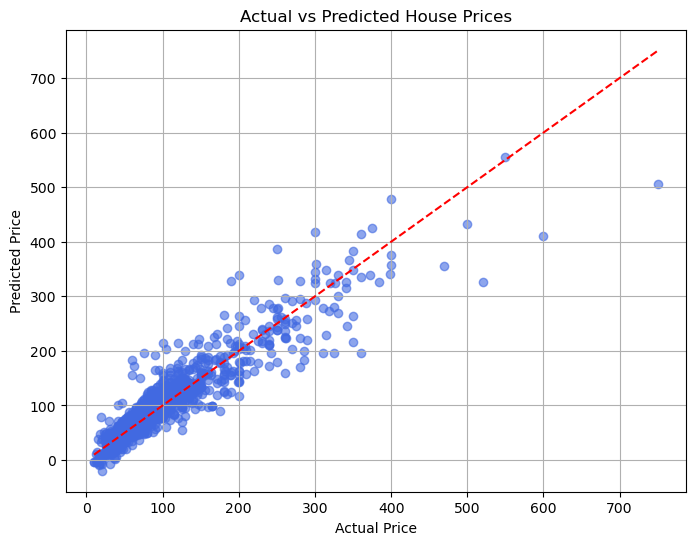

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='royalblue')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted House Prices")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.grid(True)
plt.show()


## Residual Plot:

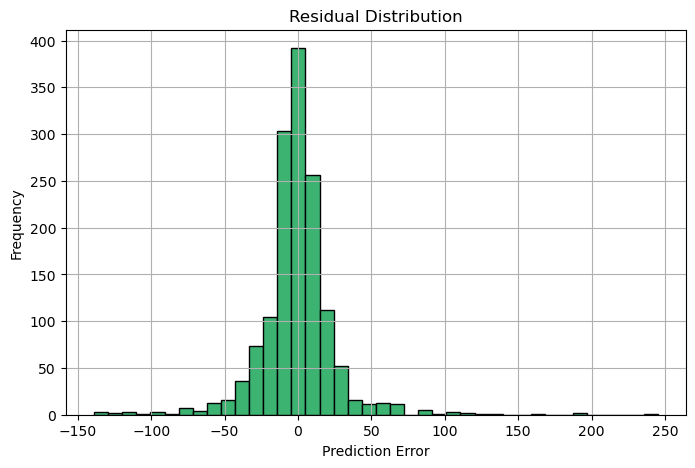

In [78]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=40, color='mediumseagreen', edgecolor='black')
plt.title("Residual Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [79]:
X.columns

Index(['total_sqft', 'bath', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=243)

In [80]:
np.where(X.columns=='2nd Phase Judicial Layout')[0][0]

5

<h2 style='color:blue'>Test the model for few properties</h2>

In [81]:
def predict_price(location,sqft,bath,bhk):
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return model.predict([x])[0]

In [82]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

83.86570258312554

In [83]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

86.08062284987331

In [84]:
predict_price('Indira Nagar',1000, 2, 2)

193.31197733180028

In [85]:
predict_price('Indira Nagar',1000, 3, 3)

195.5268975985481

<h2 style='color:blue'>Export the tested model to a pickle file</h2>

In [86]:
import pickle
with open('bengaluru_home_prices_model.pickle','wb') as f:
    pickle.dump(model, f)



<h2 style='color:blue'>Export location and column information to a file that will be useful later on in our prediction application</h2>

In [87]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))